## **Versión 4:**


1.   No Global Pooling
2.   Conv Layers: 64,128,256,512
3.   Kernels 5,3,3,3
4.   Dropout 0.25 en todos salvo en la primera capa
5.   Sin Data Augmentation (solo flipeo horizontal)
6.   MUCHAS MAS CAPAS

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'itba-cifar-100-2024-q-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77584%2F8490010%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T172917Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D24e87be5967ac856532fe02c02865d08d214fe5b5b0671b716aa12d609cdc6808060a20633ad2f5d3e527a57ad71528ba4ea606f140642336896a9b4ad8bb8730a002a0158f978ddd00ab1e10200bba30069ff529339f03b589d44743c9dc59b93351148bc4da3b1c614ab8ad7e8c82b400824b04381bc58382cdfce536eecb4e11f86b2d5703974889ba0d6f58bf9fd59aab52010d03499273effbbb2c22e1b277c9b202ee75b728d884a74f86605901e740011a57eb145fe01cf5276b08df82e04a730662e44791df374bf9cb92ef0929c4da08b6b5b416429451cdd6bea5056a49e1bbcb77a9c6dcbca2ae10de69c8eb9b1f45b71a0055d12d0d43f0f60c7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 168426762 bytes downloaded
Downloaded and uncompressed: itba-cifar-100-2024-q-1
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck


In [ ]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
#Preprocesamiento de la data

# Load the data
x_train_0 = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.0
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")/255.0
y_train_fine = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

import matplotlib.pyplot as plt

# Split the training data into training and validation sets
x_train_1, x_val, y_train, y_val = train_test_split(x_train_0, y_train_fine, test_size=0.2, random_state=42)
print("Size of x_train_1:", x_train_1.shape)
print("Size of x_val:", x_val.shape)


# Convert labels to one-hot encoding
num_classes = 100
y_train_ = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

Size of x_train_1: (40000, 32, 32, 3)
Size of x_val: (10000, 32, 32, 3)


In [ ]:
# Normalization (al final no jaja)
x_train_norm=x_train_1

In [ ]:
# Data augmentation

# Primer approach a data augmentation
x_train_flipped = np.flip(x_train_norm, axis=2)
x_train = np.concatenate((x_train_norm, x_train_flipped), axis=0)
y_train = np.concatenate((y_train_, y_train_), axis=0)

print("Size of x_train:", x_train.shape)
print("Size of y_train:", y_train.shape)

Size of x_train: (80000, 32, 32, 3)
Size of y_train: (80000, 100)


In [ ]:
input_shape = x_train.shape[1:]  # (32, 32, 3)
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D,BatchNormalization

model = models.Sequential()

model.add(Conv2D(256,(5,5),padding='same',input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# Fully Connected Layer
model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))   # Probar tmb con 1024
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())    # BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), gamma_initializer=Constant(value=0.9))


# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))


# Compile the model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


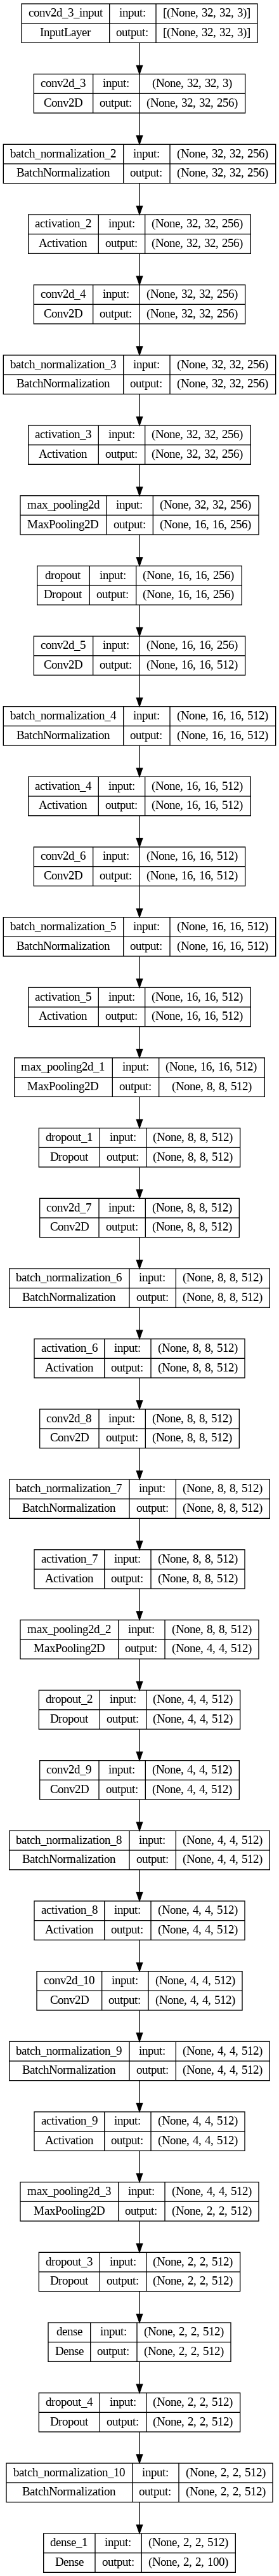

In [ ]:
import keras
from keras import utils
dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       19456     
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 256)       1024      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 32, 32, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 256)       1024      
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 32, 32, 256)      

In [ ]:
# Callbacks

from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam

# Model Checkpoint
mc = ModelCheckpoint(
    "best.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

# Reduce Learning Rate on Plateau
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

# Early Stopping
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    restore_best_weights = True,
)

# Tensorboard
tb = TensorBoard(
    log_dir="logs",
)

In [ ]:
# Train the model

history = model.fit(x_train, y_train, batch_size=64,
                    epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks= [rlrop, es, mc, tb,])

Epoch 1/200


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (64, 100) and (64, 2, 2, 100) are incompatible


In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions = predictions.argmax(axis=1)

In [ ]:
predictions

In [ ]:
import pandas as pd
df = pd.DataFrame(predictions, columns=["Label"])

In [ ]:
df.index.name = "Id"

In [ ]:
#df.to_csv("Sub_Glb_Pool_64_128_256_512_Flip_Only.csv")

## Test Labels

In [ ]:
y_test = [49, 33, 72, 51, 71, 92, 15, 14, 23, 0, 71, 75, 81, 69, 40, 43, 92, 97, 70, 53, 70, 49, 75, 29, 21, 16, 39, 8, 8, 70, 20, 61, 41, 93, 56, 73, 58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17, 4, 6, 9, 57, 2, 32, 71, 52, 42, 69, 77, 27, 15, 65, 7, 35, 43, 82, 63, 92, 66, 90, 67, 91, 32, 32, 82, 10, 77, 22, 71, 78, 54, 6, 29, 89, 78, 33, 11, 67, 22, 18, 27, 21, 13, 21, 50, 75, 37, 35, 26, 83, 47, 95, 43, 69, 76, 17, 57, 59, 25, 20, 27, 0, 9, 71, 8, 43, 57, 56, 85, 10, 19, 92, 33, 20, 21, 50, 70, 46, 11, 16, 1, 74, 33, 91, 60, 64, 52, 23, 4, 11, 52, 37, 24, 95, 25, 39, 51, 58, 58, 77, 18, 59, 45, 66, 58, 20, 24, 4, 36, 8, 87, 10, 30, 47, 54, 99, 51, 83, 9, 37, 4, 83, 95, 83, 32, 73, 18, 40, 39, 64, 22, 80, 28, 28, 40, 95, 98, 83, 12, 24, 45, 13, 94, 24, 58, 63, 7, 87, 6, 78, 68, 60, 6, 23, 44, 31, 80, 93, 73, 98, 49, 90, 97, 59, 2, 67, 16, 81, 94, 27, 76, 77, 12, 18, 0, 76, 79, 71, 89, 57, 47, 24, 65, 0, 32, 36, 82, 31, 23, 24, 34, 21, 11, 53, 80, 44, 4, 39, 91, 16, 36, 68, 50, 97, 58, 31, 6, 42, 80, 76, 89, 55, 19, 91, 70, 1, 6, 62, 99, 51, 96, 83, 42, 18, 67, 66, 40, 62, 78, 84, 28, 89, 30, 66, 18, 38, 42, 92, 27, 11, 86, 44, 96, 12, 16, 67, 43, 89, 96, 12, 40, 7, 86, 77, 76, 31, 18, 28, 19, 18, 41, 42, 43, 31, 93, 15, 10, 8, 37, 89, 32, 67, 12, 2, 19, 91, 94, 7, 71, 36, 61, 62, 5, 60, 45, 91, 34, 95, 9, 40, 68, 62, 99, 66, 46, 7, 10, 10, 68, 34, 37, 58, 48, 40, 96, 14, 11, 66, 64, 39, 33, 94, 63, 10, 89, 92, 90, 65, 90, 33, 28, 29, 87, 86, 7, 0, 94, 11, 26, 6, 41, 21, 69, 27, 29, 67, 85, 65, 40, 57, 72, 30, 74, 27, 3, 49, 52, 95, 40, 93, 77, 91, 6, 57, 72, 16, 98, 89, 40, 96, 71, 3, 2, 66, 27, 8, 53, 33, 55, 81, 88, 96, 68, 42, 77, 10, 27, 32, 79, 98, 18, 51, 2, 19, 31, 67, 36, 10, 16, 5, 81, 85, 26, 85, 65, 22, 55, 85, 22, 22, 10, 18, 98, 9, 26, 27, 7, 5, 58, 87, 76, 2, 54, 38, 33, 17, 6, 0, 79, 97, 14, 14, 73, 79, 8, 42, 4, 25, 37, 75, 74, 41, 0, 99, 79, 87, 67, 72, 38, 25, 49, 3, 74, 69, 36, 77, 89, 71, 31, 50, 90, 11, 2, 41, 38, 58, 47, 93, 68, 11, 35, 67, 54, 53, 30, 36, 83, 54, 64, 46, 45, 98, 62, 46, 95, 88, 37, 18, 29, 63, 8, 33, 35, 6, 76, 19, 99, 53, 15, 57, 2, 27, 27, 93, 81, 54, 71, 26, 25, 35, 30, 72, 8, 42, 62, 56, 78, 47, 73, 43, 20, 83, 63, 49, 28, 26, 45, 36, 36, 68, 1, 2, 99, 9, 65, 38, 58, 96, 38, 87, 82, 22, 83, 41, 7, 12, 10, 35, 44, 81, 91, 56, 9, 24, 3, 30, 1, 39, 98, 72, 83, 80, 43, 84, 66, 4, 64, 77, 98, 82, 81, 20, 0, 48, 46, 33, 22, 13, 17, 39, 76, 0, 17, 64, 48, 90, 93, 82, 75, 96, 97, 3, 83, 60, 61, 32, 26, 84, 41, 12, 85, 12, 8, 82, 72, 94, 7, 22, 15, 66, 89, 97, 19, 0, 19, 5, 56, 36, 45, 1, 94, 66, 86, 82, 17, 64, 99, 34, 30, 73, 83, 6, 1, 28, 77, 91, 74, 68, 14, 14, 1, 92, 97, 45, 7, 21, 37, 32, 73, 88, 86, 92, 14, 86, 74, 25, 93, 78, 77, 88, 42, 10, 65, 26, 31, 85, 78, 29, 32, 81, 97, 1, 82, 0, 21, 15, 56, 57, 97, 76, 60, 87, 46, 1, 61, 75, 62, 21, 61, 78, 90, 68, 94, 88, 95, 3, 83, 32, 93, 77, 38, 63, 61, 41, 88, 83, 35, 82, 50, 15, 48, 25, 4, 71, 8, 98, 67, 7, 85, 25, 96, 60, 55, 80, 13, 90, 54, 15, 76, 39, 95, 24, 7, 64, 70, 88, 81, 0, 12, 64, 31, 79, 86, 60, 22, 38, 82, 14, 48, 33, 55, 53, 40, 1, 58, 94, 70, 29, 86, 23, 46, 58, 99, 78, 10, 53, 37, 97, 65, 15, 77, 52, 63, 32, 6, 36, 6, 7, 36, 74, 13, 22, 32, 54, 62, 84, 57, 25, 11, 62, 85, 31, 26, 16, 96, 71, 90, 39, 20, 47, 35, 19, 52, 66, 32, 53, 53, 21, 98, 6, 88, 71, 45, 98, 55, 99, 24, 93, 67, 33, 16, 33, 9, 10, 46, 68, 24, 96, 22, 40, 63, 53, 10, 14, 41, 77, 54, 84, 20, 29, 76, 36, 1, 26, 99, 2, 96, 69, 36, 18, 90, 66, 52, 37, 99, 97, 12, 55, 15, 85, 15, 16, 33, 99, 80, 28, 69, 51, 72, 39, 8, 56, 59, 15, 21, 77, 45, 21, 80, 89, 37, 48, 47, 56, 65, 96, 14, 52, 2, 60, 9, 68, 22, 23, 44, 19, 54, 97, 23, 54, 62, 56, 23, 42, 81, 66, 87, 47, 47, 45, 42, 51, 10, 35, 68, 13, 55, 34, 74, 47, 40, 51, 6, 3, 76, 52, 53, 34, 60, 63, 28, 24, 36, 69, 82, 90, 70, 75, 77, 43, 43, 78, 81, 80, 66, 35, 84, 21, 49, 96, 15, 37, 2, 89, 36, 9, 53, 91, 65, 67, 94, 40, 72, 90, 86, 85, 30, 92, 25, 60, 2, 29, 0, 9, 37, 1, 50, 90, 27, 52, 36, 48, 71, 12, 97, 0, 3, 41, 21, 16, 51, 72, 13, 63, 81, 73, 55, 30, 28, 10, 84, 8, 6, 9, 93, 2, 78, 26, 16, 17, 39, 67, 20, 3, 81, 26, 96, 45, 15, 29, 57, 60, 49, 36, 23, 63, 72, 19, 41, 55, 26, 25, 49, 28, 20, 33, 7, 45, 7, 89, 1, 90, 42, 15, 23, 93, 96, 59, 29, 29, 75, 93, 8, 70, 48, 82, 84, 81, 72, 38, 80, 63, 76, 4, 54, 60, 1, 49, 1, 92, 77, 30, 98, 62, 25, 26, 55, 25, 21, 25, 82, 80, 19, 93, 35, 61, 81, 69, 9, 91, 96, 34, 23, 9, 0, 28, 51, 91, 65, 33, 5, 13, 52, 58, 65, 32, 37, 63, 61, 19, 2, 49, 64, 58, 93, 62, 52, 53, 41, 33, 84, 22, 67, 44, 95, 24, 46, 98, 31, 83, 16, 2, 47, 51, 3, 18, 60, 38, 95, 89, 11, 63, 15, 49, 63, 85, 12, 38, 66, 99, 72, 83, 12, 93, 51, 21, 47, 21, 43, 77, 55, 36, 57, 69, 5, 29, 41, 14, 41, 77, 58, 60, 45, 88, 19, 19, 48, 5, 81, 69, 77, 60, 88, 92, 31, 34, 36, 30, 64, 82, 88, 7, 38, 57, 92, 23, 11, 41, 38, 90, 76, 28, 24, 6, 84, 76, 88, 28, 98, 96, 93, 64, 45, 54, 26, 79, 70, 46, 89, 89, 64, 93, 39, 53, 36, 50, 56, 84, 46, 13, 5, 51, 5, 56, 68, 70, 92, 93, 28, 18, 37, 50, 81, 67, 41, 35, 99, 41, 79, 90, 59, 59, 35, 16, 17, 64, 90, 96, 3, 88, 3, 45, 0, 68, 33, 49, 0, 18, 22, 72, 4, 66, 5, 46, 79, 70, 9, 49, 34, 48, 71, 37, 42, 6, 91, 58, 42, 17, 1, 5, 65, 5, 38, 47, 38, 63, 61, 28, 99, 20, 88, 50, 53, 97, 59, 78, 35, 50, 6, 98, 33, 65, 23, 68, 26, 96, 17, 65, 47, 12, 94, 81, 76, 91, 72, 35, 18, 96, 92, 98, 19, 0, 43, 50, 43, 44, 73, 4, 53, 37, 8, 25, 52, 29, 44, 12, 38, 5, 25, 41, 81, 23, 68, 59, 81, 43, 8, 11, 18, 92, 5, 34, 48, 80, 25, 31, 8, 88, 10, 50, 76, 50, 95, 94, 83, 52, 44, 16, 99, 68, 28, 15, 47, 34, 57, 13, 22, 9, 90, 50, 34, 43, 20, 87, 91, 80, 9, 17, 19, 57, 14, 27, 46, 13, 44, 24, 10, 84, 4, 56, 29, 29, 51, 78, 62, 53, 17, 28, 28, 11, 65, 48, 48, 12, 55, 66, 98, 8, 94, 25, 70, 54, 12, 86, 3, 76, 13, 2, 7, 91, 55, 45, 51, 53, 28, 9, 87, 13, 30, 58, 61, 31, 70, 39, 3, 47, 34, 26, 50, 59, 64, 37, 92, 14, 26, 37, 94, 29, 15, 63, 7, 32, 9, 43, 12, 27, 78, 97, 55, 11, 69, 66, 31, 20, 54, 45, 86, 84, 55, 3, 6, 54, 69, 47, 62, 57, 85, 30, 16, 11, 82, 65, 59, 81, 39, 79, 25, 44, 16, 23, 17, 49, 69, 74, 63, 10, 56, 43, 22, 11, 9, 17, 31, 52, 52, 36, 58, 79, 42, 32, 15, 15, 79, 56, 3, 77, 57, 5, 76, 84, 47, 79, 64, 3, 22, 84, 15, 83, 19, 64, 61, 33, 16, 76, 96, 87, 92, 39, 60, 59, 74, 27, 68, 7, 23, 42, 47, 2, 20, 80, 24, 17, 12, 55, 13, 17, 67, 21, 42, 21, 46, 79, 21, 61, 64, 41, 16, 40, 54, 70, 65, 84, 64, 37, 59, 92, 71, 17, 96, 94, 39, 93, 79, 34, 26, 33, 24, 12, 53, 88, 20, 47, 98, 25, 45, 25, 61, 56, 68, 27, 13, 92, 12, 46, 76, 67, 27, 2, 78, 48, 3, 98, 20, 8, 43, 57, 63, 7, 10, 47, 46, 52, 90, 69, 78, 15, 78, 29, 61, 5, 30, 86, 85, 33, 10, 44, 34, 24, 56, 61, 62, 38, 72, 44, 53, 7, 38, 17, 40, 91, 83, 82, 10, 21, 30, 65, 47, 57, 16, 81, 30, 72, 96, 88, 62, 95, 27, 61, 2, 50, 21, 87, 5, 69, 37, 59, 0, 78, 20, 85, 54, 53, 73, 69, 3, 35, 49, 33, 73, 99, 97, 89, 3, 54, 90, 45, 11, 1, 51, 28, 79, 47, 54, 83, 40, 14, 26, 27, 12, 42, 44, 29, 59, 8, 17, 56, 46, 80, 1, 82, 51, 34, 86, 96, 86, 93, 38, 20, 19, 2, 20, 91, 55, 65, 64, 90, 70, 34, 11, 55, 68, 52, 6, 79, 22, 22, 86, 10, 1, 75, 48, 5, 90, 67, 99, 33, 82, 76, 51, 92, 65, 77, 70, 12, 91, 83, 95, 48, 52, 30, 49, 11, 3, 17, 80, 94, 29, 87, 49, 64, 57, 42, 95, 28, 16, 99, 46, 31, 25, 2, 95, 21, 83, 59, 56, 28, 17, 53, 71, 7, 94, 53, 89, 10, 28, 7, 36, 79, 53, 87, 43, 76, 69, 22, 17, 6, 53, 68, 44, 89, 15, 80, 45, 95, 37, 80, 28, 13, 23, 52, 24, 21, 55, 99, 98, 21, 59, 9, 81, 88, 93, 61, 17, 44, 49, 81, 78, 94, 40, 60, 80, 58, 4, 88, 18, 24, 36, 26, 74, 88, 56, 3, 65, 0, 43, 22, 47, 65, 22, 69, 9, 78, 4, 69, 46, 97, 29, 18, 64, 98, 65, 36, 94, 84, 91, 20, 36, 50, 76, 29, 63, 6, 30, 99, 55, 21, 38, 83, 67, 31, 49, 39, 66, 66, 53, 54, 41, 36, 61, 88, 30, 19, 95, 41, 89, 19, 46, 78, 37, 31, 22, 2, 78, 13, 73, 51, 95, 2, 38, 98, 28, 18, 42, 7, 88, 61, 12, 8, 92, 41, 33, 65, 17, 51, 99, 35, 67, 63, 63, 9, 58, 96, 77, 1, 36, 53, 83, 13, 98, 21, 35, 39, 49, 81, 35, 3, 77, 89, 30, 85, 59, 48, 98, 38, 80, 39, 82, 43, 12, 21, 18, 25, 5, 25, 63, 78, 4, 40, 29, 15, 39, 49, 93, 39, 77, 69, 53, 64, 12, 57, 5, 17, 97, 37, 48, 79, 5, 83, 16, 41, 48, 54, 79, 67, 73, 0, 19, 14, 29, 84, 48, 36, 76, 95, 20, 59, 57, 67, 6, 71, 21, 7, 91, 92, 87, 91, 16, 86, 58, 89, 97, 83, 72, 85, 41, 3, 20, 10, 74, 49, 63, 91, 56, 92, 19, 64, 28, 11, 41, 81, 90, 89, 86, 22, 41, 50, 27, 87, 21, 34, 36, 90, 94, 71, 31, 62, 95, 33, 38, 95, 41, 24, 89, 15, 81, 8, 48, 30, 52, 79, 20, 68, 16, 78, 45, 31, 66, 52, 43, 20, 98, 24, 71, 49, 44, 46, 62, 22, 11, 89, 99, 73, 26, 53, 10, 41, 12, 2, 4, 39, 19, 56, 74, 79, 73, 46, 3, 22, 6, 59, 54, 87, 2, 87, 49, 91, 37, 53, 51, 7, 99, 13, 25, 66, 80, 22, 73, 83, 14, 42, 86, 22, 90, 74, 24, 84, 91, 97, 88, 4, 26, 22, 19, 67, 73, 84, 98, 6, 35, 29, 51, 59, 62, 60, 68, 44, 83, 0, 41, 90, 48, 82, 67, 28, 28, 71, 79, 43, 17, 5, 17, 7, 84, 57, 27, 57, 68, 26, 59, 4, 87, 99, 3, 66, 38, 15, 75, 20, 47, 0, 14, 85, 62, 55, 63, 69, 3, 77, 73, 38, 59, 52, 84, 37, 60, 21, 96, 68, 16, 19, 40, 70, 61, 10, 57, 81, 68, 12, 10, 38, 10, 47, 76, 11, 72, 23, 1, 14, 31, 30, 93, 54, 9, 15, 2, 26, 65, 32, 12, 58, 73, 76, 95, 67, 95, 26, 92, 47, 84, 29, 51, 44, 45, 60, 34, 97, 1, 93, 97, 19, 19, 92, 69, 65, 95, 78, 5, 34, 76, 25, 50, 30, 69, 59, 34, 77, 46, 66, 31, 73, 87, 90, 18, 6, 38, 81, 25, 81, 64, 70, 37, 76, 31, 0, 90, 32, 5, 56, 41, 80, 5, 52, 51, 25, 20, 61, 98, 20, 32, 35, 5, 72, 61, 43, 58, 36, 99, 60, 70, 38, 59, 26, 56, 78, 83, 23, 52, 32, 54, 33, 61, 49, 53, 15, 50, 3, 12, 86, 55, 58, 5, 30, 26, 10, 0, 11, 9, 33, 53, 33, 94, 46, 99, 34, 1, 17, 63, 69, 66, 37, 67, 40, 93, 24, 82, 23, 30, 66, 30, 11, 11, 94, 88, 37, 29, 46, 95, 54, 41, 6, 19, 22, 3, 32, 55, 53, 72, 33, 20, 63, 12, 64, 23, 22, 75, 8, 33, 66, 55, 72, 73, 84, 13, 96, 65, 22, 0, 19, 80, 23, 85, 68, 86, 37, 81, 35, 98, 8, 23, 76, 74, 89, 60, 69, 96, 32, 29, 64, 9, 16, 0, 74, 17, 54, 62, 6, 34, 65, 8, 46, 67, 53, 23, 78, 61, 26, 64, 25, 70, 96, 67, 22, 45, 65, 96, 79, 23, 76, 26, 57, 16, 64, 34, 82, 66, 83, 72, 71, 9, 60, 35, 43, 29, 93, 58, 94, 5, 83, 92, 26, 39, 86, 93, 16, 85, 27, 76, 89, 42, 18, 14, 4, 73, 71, 20, 20, 16, 51, 88, 5, 25, 64, 59, 77, 22, 3, 68, 28, 44, 13, 73, 98, 52, 44, 99, 17, 31, 50, 87, 44, 85, 58, 57, 45, 28, 5, 11, 81, 46, 67, 96, 69, 19, 55, 75, 31, 97, 66, 51, 71, 29, 4, 89, 99, 67, 39, 52, 59, 12, 96, 16, 36, 64, 27, 81, 37, 11, 85, 50, 35, 78, 6, 72, 70, 74, 42, 0, 41, 39, 87, 80, 44, 47, 95, 10, 21, 63, 55, 69, 20, 85, 78, 23, 13, 92, 98, 84, 75, 10, 4, 52, 55, 61, 89, 57, 50, 42, 40, 91, 88, 73, 49, 20, 2, 16, 26, 91, 88, 85, 28, 27, 83, 54, 65, 71, 77, 13, 56, 76, 37, 3, 72, 63, 46, 75, 90, 26, 60, 49, 50, 15, 2, 78, 94, 86, 25, 11, 13, 4, 40, 47, 44, 90, 95, 78, 7, 78, 39, 40, 69, 72, 64, 47, 60, 78, 36, 75, 36, 82, 88, 38, 36, 81, 72, 50, 2, 52, 68, 44, 6, 53, 56, 32, 46, 34, 83, 74, 19, 43, 77, 87, 26, 63, 5, 79, 85, 38, 80, 59, 5, 73, 32, 15, 24, 93, 2, 88, 49, 11, 38, 62, 7, 6, 61, 27, 5, 41, 37, 10, 43, 69, 21, 73, 68, 88, 10, 65, 4, 47, 59, 20, 35, 2, 88, 83, 72, 4, 3, 60, 82, 61, 68, 92, 22, 84, 87, 32, 91, 38, 36, 9, 63, 57, 50, 97, 27, 34, 69, 1, 82, 13, 84, 15, 97, 22, 27, 18, 79, 98, 74, 97, 13, 78, 88, 98, 78, 5, 4, 17, 60, 44, 69, 53, 37, 82, 44, 3, 24, 27, 6, 38, 35, 21, 0, 16, 84, 11, 41, 98, 89, 99, 31, 46, 68, 47, 47, 11, 95, 70, 23, 58, 50, 27, 8, 47, 27, 3, 68, 53, 34, 68, 96, 53, 19, 70, 21, 90, 11, 21, 4, 1, 53, 29, 93, 14, 91, 71, 88, 98, 89, 27, 71, 64, 94, 61, 20, 83, 3, 38, 99, 5, 11, 84, 88, 6, 67, 5, 31, 65, 59, 30, 97, 64, 46, 22, 51, 25, 18, 78, 56, 88, 24, 5, 22, 15, 67, 15, 2, 60, 41, 11, 70, 76, 81, 89, 24, 30, 50, 0, 75, 63, 9, 36, 20, 7, 74, 24, 73, 32, 35, 82, 87, 31, 14, 73, 47, 65, 77, 51, 61, 30, 32, 66, 29, 97, 16, 0, 82, 43, 23, 89, 9, 16, 68, 2, 45, 44, 23, 38, 56, 40, 35, 73, 0, 88, 23, 7, 42, 77, 9, 35, 96, 83, 94, 3, 90, 75, 38, 14, 71, 36, 3, 78, 21, 13, 48, 83, 50, 79, 55, 33, 21, 60, 8, 84, 92, 6, 51, 25, 27, 86, 27, 8, 21, 12, 44, 75, 27, 50, 80, 54, 94, 48, 41, 53, 14, 55, 53, 12, 7, 46, 95, 38, 67, 0, 72, 11, 27, 1, 73, 25, 47, 42, 75, 81, 69, 10, 24, 87, 35, 69, 86, 59, 84, 63, 86, 23, 82, 14, 10, 26, 62, 6, 10, 17, 76, 56, 63, 85, 99, 64, 7, 42, 24, 13, 6, 37, 16, 33, 48, 44, 80, 19, 82, 46, 33, 31, 86, 59, 3, 9, 57, 54, 43, 35, 93, 62, 88, 64, 78, 45, 36, 1, 43, 34, 71, 87, 39, 18, 57, 67, 4, 73, 41, 76, 73, 43, 94, 25, 63, 71, 15, 52, 38, 30, 64, 30, 23, 35, 74, 36, 76, 96, 17, 31, 76, 88, 3, 63, 2, 77, 49, 92, 17, 80, 89, 3, 88, 26, 41, 79, 32, 62, 55, 20, 98, 26, 17, 1, 32, 43, 85, 72, 59, 24, 13, 31, 14, 42, 40, 33, 20, 68, 23, 62, 24, 55, 10, 22, 70, 79, 73, 45, 84, 9, 70, 96, 97, 33, 67, 21, 90, 62, 57, 25, 54, 69, 40, 41, 93, 9, 83, 7, 25, 13, 90, 16, 12, 48, 50, 37, 49, 60, 36, 37, 39, 65, 91, 70, 90, 99, 10, 4, 21, 48, 36, 31, 66, 5, 92, 93, 60, 50, 93, 28, 49, 32, 79, 98, 86, 30, 64, 18, 44, 13, 99, 27, 69, 87, 6, 22, 50, 90, 71, 20, 91, 90, 71, 49, 42, 57, 20, 63, 67, 12, 91, 39, 20, 73, 52, 69, 56, 10, 51, 44, 62, 62, 43, 30, 6, 99, 35, 79, 35, 9, 20, 79, 15, 87, 37, 20, 60, 33, 67, 92, 73, 88, 38, 90, 70, 77, 84, 16, 18, 80, 51, 42, 68, 18, 24, 19, 6, 57, 21, 42, 39, 10, 20, 9, 4, 51, 1, 14, 53, 7, 60, 53, 90, 43, 62, 38, 76, 84, 46, 32, 54, 34, 29, 65, 72, 65, 10, 25, 7, 48, 90, 94, 42, 4, 55, 99, 68, 6, 24, 82, 43, 71, 31, 75, 26, 49, 98, 25, 62, 73, 2, 81, 99, 11, 31, 82, 56, 3, 88, 62, 8, 73, 20, 44, 80, 89, 0, 23, 16, 96, 24, 26, 93, 6, 53, 93, 19, 49, 11, 45, 27, 26, 82, 84, 28, 1, 56, 26, 57, 60, 18, 55, 71, 56, 47, 21, 36, 9, 41, 24, 75, 5, 32, 12, 57, 84, 76, 65, 12, 21, 23, 76, 29, 57, 75, 32, 25, 96, 56, 49, 8, 19, 98, 39, 71, 46, 3, 41, 64, 37, 8, 13, 99, 31, 35, 52, 73, 89, 2, 54, 97, 73, 95, 1, 12, 0, 51, 23, 73, 72, 83, 74, 1, 12, 38, 51, 29, 77, 44, 18, 10, 16, 43, 0, 7, 70, 17, 3, 6, 83, 65, 0, 46, 85, 62, 18, 81, 40, 48, 4, 2, 21, 24, 95, 53, 89, 50, 35, 98, 32, 58, 97, 56, 78, 60, 79, 84, 28, 46, 90, 43, 9, 42, 84, 59, 27, 17, 62, 23, 31, 11, 48, 82, 87, 28, 14, 99, 13, 66, 35, 42, 20, 2, 16, 68, 23, 93, 79, 87, 41, 2, 96, 39, 49, 57, 96, 12, 38, 65, 39, 93, 83, 32, 19, 8, 53, 69, 72, 23, 29, 43, 88, 11, 96, 62, 54, 2, 73, 34, 48, 34, 34, 94, 88, 67, 71, 97, 7, 35, 77, 95, 44, 45, 27, 80, 84, 99, 52, 92, 70, 16, 88, 25, 58, 79, 54, 73, 50, 47, 51, 78, 26, 50, 17, 86, 72, 87, 34, 47, 25, 72, 29, 95, 86, 92, 78, 3, 28, 58, 66, 78, 38, 22, 66, 95, 45, 97, 65, 54, 71, 70, 80, 85, 28, 41, 71, 64, 75, 90, 7, 37, 23, 54, 84, 86, 8, 22, 51, 75, 26, 11, 3, 46, 64, 92, 55, 39, 66, 86, 85, 0, 8, 27, 57, 13, 94, 40, 61, 94, 17, 11, 1, 4, 49, 77, 0, 1, 80, 48, 39, 55, 38, 12, 35, 12, 78, 87, 11, 0, 95, 90, 10, 88, 10, 97, 48, 63, 51, 52, 47, 85, 69, 65, 81, 30, 51, 69, 28, 4, 31, 97, 48, 64, 80, 0, 0, 5, 45, 13, 90, 85, 56, 51, 34, 44, 91, 85, 56, 10, 46, 93, 77, 81, 82, 18, 66, 56, 49, 0, 70, 63, 99, 14, 5, 26, 24, 86, 64, 55, 1, 94, 74, 6, 25, 52, 90, 5, 40, 41, 49, 76, 19, 44, 49, 57, 85, 63, 91, 63, 94, 55, 59, 21, 59, 47, 31, 60, 44, 25, 11, 97, 96, 3, 46, 85, 56, 34, 50, 41, 87, 38, 83, 45, 77, 15, 47, 68, 46, 87, 61, 69, 49, 86, 89, 36, 59, 67, 54, 72, 3, 62, 60, 97, 40, 69, 4, 94, 65, 39, 87, 48, 93, 38, 67, 26, 1, 10, 41, 47, 78, 87, 13, 11, 57, 45, 39, 8, 55, 21, 65, 97, 90, 98, 63, 78, 44, 44, 15, 53, 97, 13, 9, 75, 73, 84, 84, 48, 12, 25, 7, 90, 7, 55, 90, 86, 67, 54, 77, 60, 9, 54, 34, 68, 25, 71, 20, 89, 24, 84, 4, 59, 26, 18, 37, 98, 64, 74, 94, 5, 43, 97, 23, 93, 15, 17, 1, 58, 31, 8, 45, 28, 23, 19, 88, 87, 82, 26, 33, 63, 16, 13, 91, 76, 76, 38, 10, 70, 17, 78, 56, 75, 57, 79, 90, 38, 51, 27, 71, 96, 6, 40, 51, 47, 37, 41, 66, 67, 41, 82, 14, 23, 6, 98, 11, 7, 65, 64, 40, 15, 1, 29, 38, 75, 40, 31, 60, 79, 63, 6, 36, 31, 21, 52, 71, 1, 61, 34, 34, 77, 35, 37, 7, 70, 20, 93, 41, 92, 87, 46, 30, 30, 46, 85, 32, 14, 51, 24, 5, 49, 61, 89, 48, 98, 7, 94, 37, 94, 94, 52, 11, 61, 41, 50, 84, 76, 18, 64, 80, 62, 11, 41, 69, 34, 2, 45, 62, 87, 99, 45, 2, 27, 91, 19, 56, 20, 92, 54, 75, 9, 83, 27, 95, 49, 14, 2, 43, 96, 95, 66, 81, 9, 44, 99, 87, 79, 11, 59, 18, 62, 96, 94, 49, 47, 72, 26, 71, 76, 21, 81, 30, 99, 64, 92, 0, 6, 74, 82, 13, 69, 8, 3, 74, 89, 11, 16, 92, 79, 86, 72, 95, 38, 42, 65, 61, 68, 17, 41, 49, 20, 4, 75, 48, 13, 60, 67, 62, 17, 37, 32, 59, 59, 38, 70, 79, 11, 49, 44, 0, 26, 45, 48, 1, 33, 57, 10, 37, 97, 44, 43, 63, 55, 37, 20, 49, 19, 16, 26, 21, 79, 40, 68, 74, 95, 46, 94, 68, 13, 22, 83, 46, 74, 35, 60, 11, 21, 34, 39, 65, 13, 20, 21, 99, 68, 88, 93, 49, 69, 17, 55, 81, 63, 14, 73, 17, 13, 95, 99, 61, 24, 22, 23, 94, 33, 90, 8, 68, 52, 20, 64, 54, 53, 3, 4, 88, 53, 27, 5, 47, 97, 5, 35, 71, 54, 54, 17, 56, 54, 15, 69, 65, 24, 42, 8, 72, 77, 75, 66, 93, 94, 27, 98, 75, 44, 37, 8, 10, 84, 72, 34, 37, 2, 86, 20, 90, 49, 95, 29, 34, 46, 43, 72, 18, 51, 87, 18, 41, 93, 72, 95, 19, 34, 42, 79, 79, 17, 73, 97, 45, 97, 29, 86, 29, 0, 19, 12, 91, 75, 97, 50, 13, 61, 74, 85, 29, 67, 50, 43, 50, 3, 25, 13, 50, 56, 60, 30, 61, 34, 84, 1, 58, 35, 4, 77, 42, 22, 87, 38, 11, 9, 32, 12, 50, 8, 96, 61, 9, 43, 9, 58, 92, 32, 32, 25, 0, 34, 75, 68, 27, 15, 0, 38, 10, 3, 44, 30, 43, 59, 50, 40, 67, 76, 49, 98, 57, 16, 56, 84, 75, 50, 90, 10, 83, 22, 59, 93, 36, 51, 6, 74, 82, 1, 97, 12, 79, 49, 94, 39, 25, 98, 10, 58, 79, 54, 64, 1, 24, 46, 51, 45, 70, 29, 96, 2, 7, 95, 27, 83, 89, 7, 52, 24, 49, 5, 80, 53, 75, 55, 14, 15, 69, 51, 24, 19, 2, 68, 24, 75, 75, 41, 13, 44, 41, 31, 74, 18, 43, 0, 13, 15, 7, 17, 83, 92, 79, 34, 74, 86, 20, 50, 72, 14, 86, 88, 98, 4, 77, 1, 79, 12, 87, 78, 65, 1, 59, 48, 83, 58, 13, 56, 94, 50, 13, 55, 97, 10, 7, 21, 19, 22, 54, 75, 75, 27, 5, 75, 6, 75, 35, 19, 79, 48, 18, 12, 32, 3, 60, 65, 85, 77, 43, 65, 85, 96, 98, 66, 62, 73, 83, 65, 58, 12, 19, 38, 27, 81, 21, 29, 51, 58, 88, 89, 5, 15, 10, 37, 95, 50, 30, 74, 98, 33, 40, 50, 52, 14, 63, 72, 53, 91, 81, 73, 16, 32, 90, 33, 52, 41, 11, 38, 14, 56, 43, 80, 65, 46, 92, 52, 75, 78, 60, 70, 36, 19, 2, 8, 61, 55, 24, 47, 30, 70, 25, 7, 28, 67, 53, 28, 11, 54, 74, 66, 41, 4, 95, 47, 52, 59, 68, 21, 13, 62, 58, 92, 18, 24, 30, 78, 14, 86, 78, 76, 68, 56, 70, 31, 97, 72, 7, 84, 43, 61, 33, 42, 89, 42, 38, 92, 24, 49, 7, 52, 66, 99, 96, 34, 14, 11, 92, 29, 4, 3, 55, 61, 90, 94, 29, 90, 43, 21, 66, 57, 25, 37, 0, 1, 56, 30, 80, 93, 8, 23, 98, 64, 69, 68, 72, 1, 35, 92, 22, 52, 90, 91, 37, 71, 27, 89, 28, 56, 0, 79, 20, 18, 39, 79, 45, 96, 68, 24, 0, 42, 81, 80, 81, 87, 33, 9, 46, 59, 7, 64, 70, 25, 46, 89, 93, 58, 37, 91, 3, 57, 75, 5, 80, 70, 64, 34, 22, 54, 34, 32, 9, 31, 77, 43, 33, 79, 63, 63, 1, 99, 27, 12, 74, 93, 20, 60, 66, 40, 59, 92, 46, 47, 52, 89, 6, 93, 94, 54, 15, 96, 79, 49, 13, 41, 14, 30, 76, 21, 82, 52, 79, 4, 46, 14, 43, 32, 34, 83, 13, 19, 31, 67, 0, 95, 32, 33, 71, 8, 64, 53, 47, 22, 30, 22, 7, 84, 56, 92, 30, 23, 63, 22, 57, 24, 23, 32, 72, 82, 64, 43, 13, 98, 26, 55, 83, 12, 76, 47, 24, 92, 40, 86, 39, 31, 37, 71, 39, 72, 87, 17, 13, 39, 35, 54, 88, 1, 61, 24, 69, 4, 9, 98, 74, 58, 76, 96, 4, 84, 30, 88, 79, 5, 10, 33, 54, 36, 46, 6, 46, 86, 39, 83, 77, 69, 65, 14, 33, 61, 35, 20, 9, 37, 63, 82, 46, 72, 77, 16, 64, 46, 23, 22, 75, 78, 46, 10, 85, 7, 68, 31, 91, 28, 58, 55, 91, 19, 59, 44, 98, 27, 34, 17, 25, 58, 29, 85, 85, 25, 35, 12, 8, 34, 16, 86, 48, 49, 15, 55, 53, 99, 66, 26, 88, 64, 87, 41, 17, 40, 6, 55, 8, 95, 94, 3, 2, 56, 66, 4, 68, 11, 20, 49, 23, 72, 16, 0, 86, 59, 93, 48, 40, 33, 17, 52, 54, 94, 87, 77, 79, 5, 91, 28, 30, 7, 25, 42, 75, 31, 14, 94, 57, 63, 81, 4, 99, 45, 32, 11, 9, 59, 81, 40, 48, 6, 98, 70, 93, 0, 14, 49, 51, 4, 14, 42, 80, 68, 78, 47, 31, 62, 62, 90, 8, 9, 51, 91, 80, 79, 22, 18, 61, 62, 54, 34, 42, 33, 16, 99, 99, 27, 13, 39, 56, 53, 82, 48, 76, 82, 49, 40, 58, 58, 28, 37, 38, 93, 68, 13, 42, 35, 68, 47, 13, 91, 53, 23, 29, 89, 35, 43, 62, 15, 9, 97, 15, 44, 75, 84, 33, 41, 6, 71, 78, 17, 76, 78, 88, 49, 35, 54, 86, 12, 74, 80, 33, 49, 5, 63, 78, 41, 36, 37, 66, 98, 76, 8, 13, 53, 87, 19, 38, 18, 32, 88, 4, 78, 99, 75, 21, 74, 97, 75, 64, 52, 94, 10, 34, 14, 21, 61, 1, 80, 21, 81, 98, 69, 52, 63, 20, 91, 68, 64, 76, 5, 9, 43, 49, 55, 55, 32, 83, 42, 58, 44, 48, 15, 48, 17, 28, 35, 11, 15, 21, 81, 59, 14, 37, 75, 2, 10, 19, 58, 90, 43, 3, 71, 23, 28, 68, 80, 61, 87, 25, 89, 42, 74, 91, 47, 5, 22, 6, 58, 91, 61, 91, 71, 74, 82, 66, 30, 47, 38, 45, 54, 48, 13, 85, 3, 28, 21, 44, 27, 0, 8, 28, 27, 98, 48, 81, 36, 29, 86, 19, 82, 89, 35, 13, 42, 60, 69, 12, 89, 50, 24, 49, 12, 71, 25, 71, 46, 14, 88, 64, 13, 25, 11, 44, 17, 18, 74, 75, 14, 42, 83, 60, 30, 57, 94, 48, 75, 15, 51, 93, 93, 41, 52, 52, 12, 64, 87, 99, 86, 5, 42, 71, 64, 99, 49, 22, 52, 59, 5, 60, 71, 72, 74, 19, 56, 24, 30, 76, 15, 39, 16, 21, 15, 38, 30, 55, 98, 25, 40, 82, 3, 67, 47, 71, 52, 47, 60, 55, 16, 61, 36, 90, 32, 21, 30, 78, 43, 81, 88, 49, 96, 10, 95, 33, 15, 85, 89, 79, 26, 18, 97, 14, 15, 16, 75, 6, 92, 88, 64, 54, 71, 6, 96, 8, 67, 0, 78, 92, 57, 66, 48, 67, 60, 89, 16, 42, 58, 61, 22, 75, 37, 3, 60, 9, 27, 83, 89, 42, 88, 44, 2, 62, 94, 32, 95, 66, 8, 40, 44, 45, 26, 48, 87, 59, 35, 61, 64, 43, 25, 48, 45, 36, 29, 51, 76, 74, 61, 56, 55, 44, 50, 8, 27, 22, 61, 77, 85, 95, 78, 0, 80, 26, 33, 49, 51, 36, 98, 39, 76, 95, 31, 45, 27, 60, 3, 51, 94, 67, 6, 62, 98, 28, 26, 61, 29, 64, 95, 4, 42, 17, 99, 30, 86, 83, 78, 25, 50, 97, 67, 52, 28, 44, 28, 22, 5, 35, 37, 66, 88, 95, 1, 57, 12, 44, 97, 78, 7, 94, 85, 48, 16, 85, 63, 59, 70, 62, 58, 54, 60, 9, 44, 23, 71, 10, 89, 31, 67, 56, 42, 70, 73, 43, 43, 86, 15, 24, 84, 42, 60, 48, 19, 93, 16, 30, 13, 21, 78, 68, 48, 56, 74, 42, 20, 14, 78, 62, 76, 42, 28, 74, 78, 28, 27, 51, 83, 48, 79, 67, 43, 90, 18, 40, 88, 15, 89, 0, 80, 95, 59, 67, 57, 64, 55, 72, 39, 1, 14, 10, 40, 66, 32, 11, 4, 54, 14, 15, 84, 7, 15, 70, 45, 28, 27, 36, 31, 80, 16, 59, 6, 19, 87, 15, 81, 25, 98, 2, 68, 47, 18, 66, 66, 17, 65, 90, 98, 45, 76, 95, 5, 89, 69, 57, 60, 95, 16, 7, 52, 6, 7, 67, 60, 67, 52, 2, 94, 25, 23, 58, 65, 38, 85, 48, 82, 21, 55, 69, 39, 12, 29, 5, 17, 87, 78, 70, 30, 87, 94, 75, 44, 73, 67, 62, 41, 1, 16, 85, 80, 29, 44, 69, 26, 46, 20, 7, 93, 63, 53, 40, 37, 33, 76, 48, 63, 84, 31, 54, 28, 72, 34, 47, 63, 54, 35, 93, 61, 2, 51, 7, 59, 68, 81, 81, 39, 13, 37, 35, 81, 51, 18, 4, 23, 93, 94, 77, 47, 51, 5, 90, 86, 48, 96, 23, 79, 13, 98, 71, 60, 62, 39, 68, 52, 14, 21, 15, 77, 94, 73, 70, 59, 55, 76, 72, 3, 18, 0, 99, 24, 56, 0, 82, 72, 37, 20, 54, 11, 9, 86, 65, 78, 22, 48, 1, 33, 77, 49, 89, 36, 42, 20, 2, 32, 87, 71, 36, 95, 27, 36, 54, 92, 88, 6, 31, 54, 32, 58, 10, 64, 93, 3, 55, 49, 56, 33, 99, 62, 34, 53, 17, 93, 66, 0, 58, 4, 37, 1, 58, 66, 58, 88, 39, 40, 82, 68, 4, 55, 65, 72, 13, 17, 30, 67, 50, 1, 59, 73, 58, 90, 56, 44, 16, 32, 15, 90, 99, 56, 40, 63, 22, 2, 14, 72, 76, 73, 2, 79, 5, 39, 12, 43, 91, 97, 80, 65, 62, 33, 86, 66, 24, 62, 49, 30, 24, 73, 31, 55, 59, 46, 11, 20, 83, 80, 38, 30, 93, 65, 41, 0, 35, 54, 9, 16, 87, 81, 12, 49, 60, 81, 89, 42, 51, 36, 59, 92, 7, 94, 80, 56, 37, 63, 74, 46, 34, 88, 85, 24, 28, 56, 51, 41, 62, 7, 6, 38, 26, 22, 52, 32, 70, 28, 96, 44, 57, 13, 47, 8, 73, 17, 14, 18, 91, 82, 19, 57, 71, 16, 54, 7, 52, 26, 50, 81, 74, 50, 74, 71, 85, 8, 31, 28, 17, 26, 10, 93, 16, 0, 37, 26, 71, 34, 50, 99, 44, 58, 16, 8, 34, 35, 86, 41, 0, 19, 44, 46, 6, 42, 62, 73, 31, 73, 62, 97, 97, 0, 57, 19, 46, 53, 69, 47, 13, 84, 67, 43, 80, 59, 20, 76, 65, 79, 99, 62, 58, 55, 26, 1, 46, 90, 66, 69, 39, 71, 88, 6, 51, 34, 31, 80, 67, 78, 84, 23, 23, 68, 74, 78, 78, 86, 1, 61, 2, 72, 32, 64, 43, 60, 27, 62, 91, 81, 64, 35, 32, 91, 85, 70, 28, 59, 22, 43, 35, 9, 74, 84, 72, 81, 95, 16, 25, 12, 24, 61, 50, 9, 8, 20, 11, 49, 0, 55, 31, 18, 35, 23, 47, 47, 30, 88, 32, 40, 97, 17, 81, 76, 62, 39, 72, 95, 9, 30, 86, 98, 48, 11, 88, 9, 88, 21, 36, 55, 82, 40, 47, 10, 61, 92, 93, 15, 54, 88, 33, 35, 39, 70, 15, 36, 94, 70, 96, 70, 92, 16, 3, 86, 71, 42, 99, 16, 46, 28, 98, 42, 17, 89, 14, 57, 81, 74, 4, 10, 81, 40, 49, 29, 87, 58, 36, 65, 83, 10, 34, 12, 5, 17, 29, 80, 80, 6, 65, 9, 55, 38, 88, 28, 43, 57, 50, 99, 20, 0, 32, 90, 70, 14, 31, 88, 56, 23, 71, 4, 11, 4, 39, 66, 96, 63, 13, 39, 27, 31, 84, 7, 37, 18, 43, 96, 2, 6, 59, 78, 19, 39, 97, 6, 39, 77, 74, 52, 5, 61, 21, 20, 50, 65, 48, 39, 14, 74, 36, 12, 93, 43, 51, 79, 78, 6, 4, 36, 32, 25, 97, 94, 34, 34, 59, 22, 16, 70, 9, 25, 77, 74, 17, 28, 47, 43, 13, 50, 97, 49, 78, 68, 99, 52, 28, 80, 43, 23, 23, 55, 74, 87, 50, 5, 51, 63, 2, 57, 99, 53, 85, 74, 72, 75, 94, 95, 40, 33, 49, 64, 8, 37, 0, 86, 9, 51, 40, 9, 39, 70, 96, 44, 62, 32, 61, 35, 8, 2, 66, 66, 46, 73, 56, 20, 95, 68, 52, 94, 22, 9, 23, 11, 55, 44, 47, 20, 17, 11, 73, 96, 60, 28, 10, 0, 10, 31, 44, 29, 24, 23, 52, 60, 81, 57, 52, 87, 27, 22, 83, 22, 40, 56, 1, 45, 29, 60, 65, 7, 88, 48, 8, 29, 18, 71, 80, 55, 80, 73, 27, 5, 69, 46, 64, 42, 90, 52, 1, 39, 39, 86, 75, 2, 36, 13, 57, 30, 74, 85, 33, 6, 3, 72, 54, 47, 91, 71, 7, 98, 69, 56, 14, 50, 37, 40, 97, 72, 88, 10, 75, 83, 74, 66, 52, 52, 86, 66, 24, 69, 41, 13, 39, 5, 61, 48, 44, 23, 38, 44, 64, 30, 2, 54, 12, 21, 56, 72, 93, 46, 73, 47, 89, 24, 52, 75, 20, 67, 92, 96, 5, 63, 39, 67, 45, 67, 2, 79, 76, 27, 81, 89, 83, 60, 48, 2, 2, 30, 2, 21, 82, 90, 94, 74, 71, 75, 79, 42, 75, 14, 89, 50, 83, 42, 67, 81, 73, 52, 17, 76, 5, 42, 68, 13, 37, 94, 92, 0, 48, 15, 15, 39, 40, 82, 31, 94, 99, 68, 52, 19, 4, 54, 89, 40, 27, 97, 14, 93, 66, 74, 26, 36, 9, 66, 44, 59, 33, 79, 63, 97, 43, 48, 78, 25, 32, 18, 40, 44, 80, 16, 45, 45, 12, 99, 18, 6, 41, 46, 69, 18, 44, 34, 32, 30, 9, 72, 85, 15, 92, 5, 71, 52, 56, 88, 22, 64, 31, 63, 14, 56, 99, 72, 22, 20, 67, 57, 93, 29, 72, 91, 64, 36, 22, 49, 26, 84, 47, 34, 85, 9, 22, 29, 39, 32, 94, 93, 25, 18, 53, 12, 27, 10, 99, 88, 16, 91, 78, 7, 72, 12, 97, 37, 86, 87, 57, 36, 35, 44, 57, 27, 31, 3, 26, 7, 96, 39, 43, 34, 89, 48, 56, 18, 45, 92, 97, 8, 18, 66, 81, 37, 51, 10, 77, 97, 33, 60, 43, 10, 50, 31, 84, 49, 78, 24, 68, 98, 58, 51, 93, 36, 74, 78, 55, 50, 25, 65, 86, 35, 33, 92, 37, 71, 61, 5, 79, 71, 20, 59, 67, 28, 76, 31, 50, 62, 9, 4, 54, 38, 11, 59, 84, 63, 66, 35, 52, 73, 87, 62, 15, 11, 59, 20, 47, 96, 26, 36, 35, 77, 38, 24, 2, 17, 36, 80, 74, 41, 32, 23, 76, 44, 91, 21, 81, 53, 55, 47, 79, 19, 31, 82, 64, 3, 49, 35, 97, 58, 43, 20, 86, 22, 32, 18, 53, 60, 36, 83, 18, 32, 66, 99, 51, 35, 69, 28, 11, 22, 49, 21, 93, 1, 55, 51, 55, 51, 67, 92, 76, 52, 31, 82, 75, 61, 55, 90, 78, 34, 87, 39, 85, 70, 2, 14, 45, 1, 95, 90, 64, 55, 12, 91, 47, 2, 99, 79, 13, 8, 84, 27, 11, 71, 21, 28, 8, 55, 67, 75, 40, 17, 4, 95, 63, 51, 48, 65, 6, 39, 39, 42, 49, 14, 83, 23, 78, 47, 81, 41, 76, 99, 97, 24, 24, 76, 57, 80, 16, 44, 54, 92, 30, 4, 2, 1, 39, 98, 90, 74, 81, 74, 64, 42, 59, 69, 67, 66, 10, 52, 22, 11, 69, 39, 15, 77, 36, 23, 41, 94, 45, 17, 14, 62, 9, 4, 37, 13, 77, 69, 72, 22, 75, 45, 3, 8, 24, 28, 4, 57, 10, 2, 0, 89, 7, 94, 68, 66, 17, 5, 90, 77, 34, 77, 26, 35, 52, 70, 29, 94, 37, 83, 40, 0, 92, 96, 4, 78, 80, 6, 85, 59, 96, 8, 70, 62, 25, 22, 1, 82, 93, 82, 96, 70, 8, 19, 67, 4, 86, 19, 17, 32, 38, 57, 84, 10, 40, 12, 33, 94, 68, 8, 89, 69, 95, 43, 60, 11, 0, 12, 90, 2, 54, 45, 65, 50, 3, 68, 17, 35, 81, 32, 9, 99, 77, 84, 22, 30, 23, 36, 73, 80, 92, 92, 31, 9, 86, 91, 26, 85, 30, 12, 54, 39, 76, 45, 67, 51, 57, 19, 48, 81, 55, 38, 27, 54, 81, 84, 0, 64, 42, 77, 52, 92, 82, 12, 89, 53, 21, 18, 92, 36, 44, 35, 31, 62, 41, 65, 28, 20, 92, 33, 21, 86, 72, 18, 56, 88, 76, 71, 48, 12, 45, 60, 99, 84, 24, 37, 86, 76, 84, 51, 60, 97, 29, 65, 88, 7, 83, 59, 96, 53, 32, 79, 87, 33, 46, 22, 38, 47, 24, 3, 54, 85, 65, 75, 4, 80, 76, 92, 84, 61, 31, 66, 39, 29, 35, 91, 64, 7, 80, 96, 89, 83, 32, 1, 85, 75, 9, 25, 87, 59, 38, 82, 27, 6, 26, 34, 14, 14, 46, 70, 17, 84, 97, 49, 69, 59, 50, 86, 61, 40, 66, 50, 29, 49, 26, 53, 73, 85, 46, 81, 25, 68, 71, 14, 87, 37, 86, 72, 28, 93, 62, 72, 41, 98, 51, 46, 36, 20, 57, 1, 96, 16, 38, 59, 85, 95, 23, 14, 53, 50, 2, 9, 42, 21, 12, 73, 29, 81, 63, 64, 89, 97, 63, 84, 84, 6, 3, 9, 44, 7, 39, 1, 68, 83, 71, 69, 84, 23, 51, 40, 63, 17, 31, 48, 48, 2, 50, 66, 98, 44, 12, 14, 56, 58, 70, 85, 70, 94, 41, 97, 5, 80, 15, 62, 2, 58, 56, 13, 72, 97, 25, 87, 19, 92, 24, 34, 93, 45, 78, 68, 89, 31, 73, 85, 50, 95, 80, 96, 76, 32, 77, 19, 59, 84, 48, 10, 32, 98, 33, 69, 14, 69, 36, 72, 65, 94, 86, 64, 16, 90, 56, 4, 96, 83, 71, 51, 41, 65, 61, 63, 96, 62, 85, 74, 57, 23, 20, 38, 15, 25, 72, 62, 37, 62, 15, 47, 75, 26, 28, 27, 37, 58, 46, 48, 52, 79, 71, 7, 60, 60, 38, 49, 62, 0, 19, 46, 90, 5, 22, 34, 75, 41, 65, 51, 65, 46, 1, 14, 17, 65, 98, 45, 14, 90, 35, 30, 8, 21, 28, 18, 65, 32, 34, 48, 75, 29, 92, 76, 30, 93, 4, 37, 82, 9, 11, 54, 8, 43, 67, 30, 8, 40, 53, 1, 93, 26, 93, 6, 87, 22, 91, 24, 75, 34, 86, 8, 8, 42, 51, 94, 81, 18, 85, 48, 35, 20, 50, 19, 55, 26, 64, 78, 15, 72, 93, 65, 95, 87, 72, 35, 27, 36, 97, 73, 35, 12, 24, 70, 4, 26, 71, 34, 67, 20, 85, 74, 99, 92, 99, 21, 50, 36, 82, 95, 71, 61, 23, 15, 77, 40, 74, 25, 19, 67, 6, 61, 68, 46, 5, 10, 11, 41, 55, 96, 57, 30, 96, 88, 92, 72, 51, 19, 40, 2, 76, 54, 22, 68, 70, 0, 5, 42, 11, 61, 88, 67, 77, 34, 29, 97, 13, 29, 8, 15, 70, 29, 19, 40, 47, 8, 50, 26, 89, 58, 86, 85, 61, 96, 75, 80, 95, 17, 93, 80, 3, 53, 23, 55, 27, 40, 9, 42, 50, 92, 87, 43, 42, 79, 52, 9, 32, 42, 57, 56, 99, 57, 81, 9, 70, 51, 50, 42, 10, 70, 40, 40, 63, 50, 19, 62, 28, 94, 52, 86, 98, 13, 70, 9, 19, 15, 68, 66, 24, 63, 56, 60, 12, 53, 36, 98, 20, 92, 24, 16, 26, 12, 33, 45, 71, 61, 30, 45, 75, 94, 29, 48, 97, 95, 12, 80, 63, 85, 33, 23, 32, 46, 70, 51, 8, 29, 56, 11, 60, 48, 21, 21, 60, 56, 63, 42, 33, 79, 17, 20, 16, 7, 91, 34, 14, 92, 6, 89, 13, 85, 96, 27, 81, 63, 59, 10, 78, 18, 53, 17, 27, 43, 61, 54, 25, 79, 68, 31, 69, 64, 83, 41, 23, 35, 96, 20, 87, 90, 52, 26, 83, 67, 20, 20, 7, 83, 27, 45, 68, 93, 86, 12, 60, 73, 99, 1, 92, 80, 26, 58, 88, 97, 88, 19, 34, 23, 19, 13, 44, 48, 58, 16, 63, 80, 55, 4, 32, 46, 98, 32, 45, 87, 97, 12, 8, 45, 92, 31, 62, 61, 89, 62, 78, 83, 45, 85, 28, 37, 54, 30, 95, 7, 59, 24, 94, 7, 94, 94, 11, 42, 65, 47, 40, 38, 4, 80, 82, 46, 75, 51, 74, 34, 5, 85, 30, 74, 22, 95, 81, 92, 91, 52, 51, 44, 62, 65, 76, 84, 0, 43, 48, 67, 62, 89, 83, 18, 31, 19, 8, 68, 97, 3, 83, 70, 39, 0, 86, 77, 58, 19, 89, 90, 81, 61, 41, 80, 52, 66, 68, 80, 43, 11, 25, 27, 35, 50, 88, 14, 75, 53, 3, 5, 35, 82, 7, 90, 61, 7, 91, 1, 5, 17, 72, 41, 94, 33, 67, 33, 39, 23, 6, 31, 63, 71, 67, 93, 84, 46, 74, 33, 77, 65, 50, 98, 51, 72, 36, 3, 41, 47, 54, 87, 37, 75, 74, 71, 14, 57, 9, 44, 57, 83, 45, 61, 52, 63, 89, 10, 85, 39, 7, 25, 98, 74, 70, 70, 49, 70, 87, 90, 15, 65, 97, 36, 83, 82, 51, 32, 7, 74, 80, 2, 28, 78, 40, 36, 91, 91, 99, 73, 24, 83, 42, 92, 90, 50, 82, 24, 65, 16, 40, 39, 7, 31, 10, 51, 96, 51, 29, 66, 83, 30, 84, 29, 5, 10, 53, 74, 72, 34, 15, 44, 25, 66, 10, 55, 48, 95, 63, 64, 77, 3, 13, 18, 92, 55, 13, 30, 29, 91, 91, 61, 75, 58, 60, 70, 46, 52, 94, 89, 90, 56, 57, 43, 60, 45, 30, 59, 78, 6, 80, 80, 54, 83, 60, 76, 92, 18, 14, 26, 9, 81, 85, 32, 63, 43, 56, 87, 78, 45, 99, 70, 8, 12, 65, 80, 58, 17, 39, 53, 66, 48, 25, 88, 32, 97, 87, 37, 40, 91, 16, 27, 33, 86, 89, 5, 76, 83, 74, 85, 24, 93, 32, 76, 45, 5, 52, 46, 72, 40, 58, 84, 6, 91, 38, 35, 66, 25, 79, 57, 23, 14, 15, 86, 75, 45, 6, 22, 33, 76, 52, 41, 90, 22, 34, 45, 66, 7, 95, 11, 1, 23, 3, 22, 5, 80, 93, 27, 86, 69, 92, 53, 54, 63, 18, 84, 66, 8, 59, 8, 42, 62, 29, 30, 73, 2, 96, 39, 4, 22, 45, 83, 58, 73, 18, 84, 4, 5, 2, 18, 23, 29, 85, 34, 42, 16, 86, 65, 95, 45, 97, 0, 20, 46, 44, 86, 92, 29, 85, 82, 91, 82, 17, 38, 58, 12, 26, 54, 28, 58, 79, 1, 4, 95, 10, 3, 33, 23, 91, 73, 1, 1, 35, 10, 19, 88, 11, 29, 56, 0, 54, 61, 20, 13, 17, 53, 89, 18, 81, 6, 96, 41, 26, 26, 25, 60, 22, 73, 4, 47, 24, 18, 78, 17, 7, 0, 87, 26, 95, 14, 56, 18, 12, 54, 21, 79, 8, 43, 39, 24, 40, 53, 35, 21, 31, 8, 57, 33, 82, 35, 6, 5, 40, 65, 22, 16, 64, 57, 98, 64, 88, 55, 58, 27, 36, 13, 91, 84, 9, 5, 9, 65, 85, 70, 59, 93, 2, 59, 79, 70, 34, 97, 86, 49, 18, 55, 70, 73, 38, 34, 61, 69, 37, 64, 24, 3, 78, 74, 33, 35, 1, 84, 22, 86, 4, 91, 13, 90, 68, 60, 84, 0, 34, 18, 32, 92, 14, 96, 35, 86, 3, 89, 79, 15, 66, 35, 50, 12, 41, 31, 34, 93, 84, 26, 74, 78, 50, 57, 54, 2, 95, 44, 66, 60, 26, 58, 82, 67, 98, 89, 28, 55, 95, 76, 60, 76, 91, 37, 2, 3, 62, 43, 91, 48, 63, 34, 56, 34, 53, 3, 28, 8, 40, 44, 33, 61, 60, 73, 61, 26, 59, 4, 49, 92, 92, 6, 72, 86, 18, 20, 55, 0, 85, 75, 18, 23, 74, 95, 81, 58, 73, 60, 21, 14, 19, 87, 47, 79, 90, 75, 73, 15, 41, 39, 99, 11, 94, 45, 91, 36, 77, 3, 75, 92, 94, 61, 50, 38, 12, 1, 0, 30, 84, 98, 29, 7, 18, 48, 89, 91, 84, 63, 62, 31, 40, 55, 30, 61, 86, 47, 33, 11, 25, 14, 28, 75, 11, 81, 61, 73, 79, 5, 88, 56, 81, 31, 84, 69, 30, 6, 68, 70, 12, 74, 7, 21, 55, 71, 5, 14, 48, 18, 0, 70, 38, 26, 24, 69, 16, 9, 42, 41, 39, 27, 0, 70, 85, 9, 43, 79, 77, 75, 74, 80, 42, 67, 8, 0, 36, 89, 43, 46, 69, 56, 42, 10, 71, 98, 55, 40, 16, 0, 21, 2, 1, 64, 52, 43, 83, 65, 68, 18, 1, 25, 96, 46, 47, 90, 2, 28, 37, 61, 31, 77, 4, 92, 38, 93, 28, 39, 18, 41, 44, 49, 1, 11, 19, 91, 82, 4, 60, 34, 56, 19, 32, 74, 87, 99, 72, 98, 8, 58, 93, 87, 87, 24, 35, 43, 52, 6, 4, 33, 8, 63, 26, 34, 39, 97, 47, 75, 33, 87, 49, 46, 16, 33, 76, 41, 97, 8, 75, 17, 80, 93, 27, 4, 41, 49, 30, 31, 21, 77, 90, 54, 87, 86, 37, 47, 66, 2, 73, 55, 25, 62, 26, 19, 28, 15, 14, 59, 69, 45, 92, 39, 42, 58, 49, 48, 44, 71, 48, 69, 9, 77, 25, 35, 23, 66, 66, 88, 82, 1, 39, 88, 93, 82, 7, 17, 56, 40, 70, 1, 68, 59, 69, 45, 16, 6, 85, 12, 99, 88, 40, 68, 36, 23, 17, 13, 20, 46, 75, 61, 70, 58, 42, 51, 75, 73, 70, 37, 28, 90, 95, 88, 68, 38, 95, 77, 16, 58, 99, 39, 56, 17, 33, 77, 63, 87, 75, 4, 16, 94, 55, 76, 60, 97, 1, 0, 75, 31, 55, 71, 75, 52, 6, 43, 14, 84, 14, 51, 1, 88, 53, 66, 5, 56, 32, 52, 40, 24, 86, 54, 54, 88, 61, 87, 54, 24, 10, 85, 17, 90, 22, 86, 77, 79, 94, 45, 0, 39, 89, 82, 41, 87, 91, 73, 4, 62, 72, 98, 10, 11, 28, 38, 74, 70, 13, 7, 15, 24, 76, 98, 67, 79, 15, 47, 47, 93, 73, 13, 26, 70, 95, 60, 70, 11, 82, 66, 34, 6, 65, 62, 74, 46, 36, 88, 96, 48, 79, 50, 19, 83, 66, 68, 97, 64, 16, 61, 16, 84, 18, 29, 63, 57, 9, 38, 43, 74, 15, 1, 67, 91, 1, 84, 69, 13, 10, 33, 80, 68, 30, 8, 3, 13, 45, 18, 20, 35, 28, 93, 5, 53, 34, 27, 93, 18, 44, 93, 37, 77, 46, 31, 69, 47, 57, 30, 85, 80, 1, 82, 45, 66, 18, 58, 31, 42, 23, 90, 18, 83, 19, 51, 80, 23, 64, 61, 40, 51, 99, 28, 19, 63, 7, 97, 78, 34, 84, 13, 50, 17, 28, 29, 10, 57, 83, 83, 53, 73, 7, 59, 82, 34, 15, 68, 68, 34, 82, 75, 37, 8, 94, 16, 24, 21, 8, 96, 53, 49, 38, 85, 27, 32, 96, 20, 29, 43, 69, 94, 26, 92, 23, 91, 34, 48, 71, 53, 25, 0, 59, 57, 69, 73, 27, 12, 42, 61, 21, 72, 88, 28, 15, 24, 1, 77, 67, 82, 5, 64, 51, 52, 79, 70, 46, 1, 59, 87, 68, 88, 76, 45, 15, 79, 1, 35, 94, 79, 16, 49, 26, 72, 60, 73, 9, 75, 5, 72, 27, 67, 38, 18, 45, 36, 40, 96, 35, 7, 85, 30, 14, 51, 79, 76, 99, 86, 15, 29, 63, 66, 62, 80, 24, 57, 43, 78, 33, 99, 95, 93, 72, 71, 77, 86, 64, 4, 23, 62, 50, 17, 98, 21, 32, 57, 99, 2, 6, 70, 82, 82, 94, 95, 81, 96, 77, 33, 67, 31, 60, 7, 74, 63, 62, 82, 36, 12, 31, 47, 75, 77, 29, 94, 27, 70, 95, 32, 38, 67, 37, 2, 65, 40, 53, 87, 95, 53, 42, 43, 89, 69, 93, 81, 84, 71, 31, 33, 73, 75, 85, 47, 97, 54, 13, 24, 46, 62, 92, 53, 98, 66, 45, 48, 94, 16, 69, 60, 27, 35, 59, 47, 44, 57, 4, 83, 89, 71, 58, 52, 46, 58, 98, 22, 62, 47, 2, 58, 77, 96, 86, 33, 13, 69, 97, 14, 51, 2, 4, 29, 58, 44, 6, 80, 81, 99, 28, 50, 57, 88, 25, 38, 71, 47, 53, 48, 79, 59, 29, 82, 90, 26, 81, 17, 14, 69, 25, 32, 39, 14, 89, 3, 67, 78, 28, 98, 88, 20, 3, 18, 60, 48, 69, 18, 41, 6, 39, 44, 15, 37, 57, 48, 98, 89, 67, 77, 38, 71, 21, 96, 11, 13, 84, 73, 58, 73, 35, 31, 83, 59, 77, 50, 41, 89, 19, 54, 4, 68, 9, 91, 67, 19, 40, 71, 57, 38, 9, 82, 3, 76, 20, 60, 42, 94, 26, 72, 6, 25, 61, 36, 4, 14, 61, 60, 14, 62, 27, 66, 16, 67, 93, 23, 33, 88, 18, 58, 0, 83, 23, 85, 56, 20, 45, 20, 30, 96, 19, 15, 98, 51, 26, 0, 56, 47, 57, 59, 10, 51, 65, 3, 23, 9, 77, 43, 15, 55, 77, 19, 73, 77, 7, 29, 4, 61, 64, 30, 39, 70, 19, 51, 9, 17, 28, 45, 28, 12, 83, 49, 63, 71, 12, 11, 77, 35, 29, 40, 15, 84, 19, 66, 70, 62, 34, 94, 72, 35, 50, 99, 33, 90, 16, 56, 4, 24, 60, 3, 19, 14, 23, 68, 91, 81, 61, 90, 21, 57, 22, 87, 82, 12, 38, 10, 93, 77, 84, 41, 64, 76, 25, 91, 94, 42, 79, 19, 76, 87, 18, 51, 1, 50, 37, 6, 45, 23, 0, 55, 91, 89, 95, 48, 45, 54, 69, 82, 68, 56, 94, 80, 40, 67, 71, 5, 50, 60, 79, 0, 44, 55, 46, 80, 2, 32, 92, 45, 69, 97, 13, 30, 27, 74, 8, 17, 42, 91, 11, 36, 69, 50, 57, 84, 90, 85, 3, 91, 79, 76, 13, 8, 92, 69, 82, 7, 73, 89, 32, 42, 39, 26, 80, 74, 15, 74, 16, 57, 94, 60, 33, 83, 62, 85, 48, 33, 11, 5, 2, 18, 75, 75, 4, 3, 72, 17, 89, 70, 19, 36, 77, 67, 83, 63, 2, 92, 17, 98, 99, 77, 56, 22, 84, 14, 71, 94, 44, 73, 41, 96, 91, 85, 43, 82, 40, 97, 42, 96, 47, 22, 1, 46, 78, 72, 93, 85, 18, 63, 65, 25, 44, 2, 86, 45, 59, 2, 54, 11, 56, 75, 47, 76, 20, 48, 97, 9, 45, 38, 84, 3, 36, 43, 84, 18, 6, 9, 72, 38, 6, 75, 15, 29, 35, 25, 95, 3, 58, 74, 44, 83, 91, 74, 86, 25, 38, 58, 36, 90, 8, 49, 65, 95, 92, 14, 81, 0, 58, 96, 1, 61, 59, 21, 60, 89, 82, 10, 80, 52, 65, 55, 32, 77, 69, 26, 42, 79, 46, 20, 38, 52, 15, 7, 65, 63, 96, 26, 29, 3, 79, 39, 30, 99, 2, 8, 19, 52, 69, 58, 54, 82, 3, 82, 93, 70, 99, 21, 17, 56, 64, 74, 1, 62, 61, 85, 78, 58, 28, 53, 74, 47, 5, 34, 81, 64, 77, 30, 66, 4, 45, 30, 98, 44, 95, 87, 63, 87, 26, 41, 70, 22, 21, 32, 90, 36, 85, 74, 87, 21, 87, 71, 53, 27, 63, 1, 8, 93, 98, 61, 88, 37, 10, 83, 91, 85, 34, 24, 50, 49, 12, 28, 74, 44, 58, 45, 87, 79, 32, 14, 47, 31, 77, 59, 60, 71, 25, 67, 81, 98, 54, 67, 17, 21, 1, 88, 21, 77, 95, 91, 12, 15, 82, 22, 16, 66, 25, 1, 29, 29, 73, 27, 81, 63, 53, 23, 13, 86, 44, 71, 28, 75, 98, 64, 79, 16, 8, 77, 22, 81, 87, 10, 65, 62, 49, 70, 57, 74, 64, 40, 91, 23, 13, 80, 6, 42, 46, 30, 95, 35, 5, 41, 36, 59, 12, 43, 86, 97, 53, 50, 80, 3, 61, 20, 22, 57, 25, 71, 55, 68, 20, 33, 67, 87, 16, 41, 66, 44, 25, 63, 1, 15, 42, 6, 85, 8, 2, 5, 45, 5, 71, 56, 99, 73, 78, 2, 76, 50, 30, 53, 91, 81, 65, 92, 23, 11, 95, 40, 30, 62, 35, 23, 78, 96, 67, 36, 8, 15, 4, 80, 27, 60, 7, 54, 48, 16, 57, 94, 30, 92, 43, 62, 58, 19, 23, 38, 28, 96, 95, 10, 99, 86, 53, 89, 11, 52, 58, 54, 85, 74, 72, 82, 72, 73, 43, 37, 34, 47, 52, 40, 53, 45, 8, 83, 3, 90, 40, 28, 53, 32, 59, 4, 33, 62, 89, 44, 12, 4, 89, 98, 78, 82, 91, 31, 91, 47, 9, 73, 69, 36, 57, 91, 95, 37, 61, 83, 69, 11, 80, 76, 31, 10, 90, 98, 94, 24, 39, 1, 33, 29, 29, 7, 39, 15, 99, 3, 41, 66, 80, 27, 45, 55, 32, 5, 45, 9, 72, 33, 38, 40, 24, 59, 65, 46, 38, 23, 39, 25, 97, 66, 46, 52, 29, 56, 98, 82, 41, 38, 51, 79, 19, 18, 95, 64, 78, 96, 49, 64, 40, 36, 97, 40, 45, 49, 62, 10, 56, 4, 77, 81, 91, 5, 87, 3, 50, 80, 86, 89, 17, 12, 80, 72, 79, 67, 40, 13, 98, 37, 21, 76, 32, 59, 49, 30, 60, 80, 51, 66, 87, 38, 63, 53, 4, 48, 24, 13, 31, 29, 84, 46, 61, 24, 34, 98, 45, 99, 27, 51, 91, 0, 72, 50, 57, 4, 60, 81, 86, 9, 11, 92, 99, 77, 57, 14, 2, 70, 69, 69, 32, 79, 44, 58, 0, 20, 7, 45, 82, 79, 58, 73, 58, 75, 85, 55, 70, 29, 97, 11, 53, 37, 73, 28, 86, 50, 24, 31, 95, 1, 2, 36, 59, 99, 55, 85, 0, 23, 64, 82, 62, 31, 86, 57, 72, 73, 42, 91, 84, 85, 90, 69, 82, 21, 89, 68, 68, 76, 31, 58, 8, 37, 13, 30, 78, 43, 33, 99, 42, 12, 92, 8, 82, 78, 97, 62, 74, 4, 69, 29, 97, 74, 56, 18, 74, 3, 95, 54, 53, 45, 16, 73, 29, 33, 6, 86, 19, 97, 4, 9, 53, 89, 18, 87, 26, 49, 11, 14, 65, 83, 3, 27, 30, 52, 74, 29, 96, 90, 14, 77, 65, 7, 75, 27, 16, 30, 50, 83, 14, 51, 42, 70]

## Test Accuracy

In [ ]:
import numpy as np
test_accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Test accuracy: {test_accuracy:.4f}")